In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import pickle

from pandas.api.types import CategoricalDtype
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

%matplotlib inline
DATA_PATH = './data/'
dataset = 'adult'
seed = 1
np.random.seed(seed)

C:\Users\Eli\Anaconda3\envs\tf1\lib\site-packages\ipykernel\parentpoller.py:116: UserWarning: Parent poll failed.  If the frontend dies,
                the kernel may be left running.  Please let us know
                about your system (bitness, Python, etc.) at
                ipython-dev@scipy.org
  ipython-dev@scipy.org""")


In [2]:
# load adult
# https://towardsdatascience.com/logistic-regression-classifier-on-census-income-data-e1dbef0b5738
def load_adult():
    columns = ["age",
               "workClass", 
               "fnlwgt", 
               "education", 
               "education-num",
               "marital-status", 
               "occupation", 
               "relationship",
               "race", 
               "sex", 
               "capital-gain", 
               "capital-loss",
               "hours-per-week", 
               "native-country", 
               "income"]
    
    train = pd.read_csv(os.path.join(DATA_PATH, 'adult/data'), names=columns, sep=' *, *', na_values='?', engine='python')
    test = pd.read_csv(os.path.join(DATA_PATH, 'adult/test'), names=columns, sep=' *, *', skiprows=1, na_values='?', engine='python')

#     test['income'].replace(regex=True, inplace=True, to_replace=r'\.', value=r'')
#     adult = pd.concat([test,train])
#     adult.reset_index(inplace=True, drop=True)
#     return adult,
    return train, test

In [3]:
train_data, test_data = load_adult()    

In [4]:
class ColumnsSelector(BaseEstimator, TransformerMixin):
  
    def __init__(self, type):
        print("ColumnsSelector init")
        self.type = type
  
    def fit(self, X, y=None):
        print("ColumnsSelector fit")
        return self

    def transform(self, X):
        print("ColumnsSelector transofrm")
        return X.select_dtypes(include=[self.type])

class CategoricalEncoder(BaseEstimator, TransformerMixin):
  
    def __init__(self, dropFirst=True):
        print("CategoricalEncoder init")
        self.categories = dict()
        self.dropFirst = dropFirst
    
    def fit(self, X, y=None):
        print("CategoricalEncoder fit")
        join_df = pd.concat([train_data, test_data])
        join_df = join_df.select_dtypes(include=['object'])
        for column in join_df.columns:
            self.categories[column] = join_df[column].value_counts().index.tolist()
        return self
    
    def transform(self, X):
        print("CategoricalEncoder transform")
        X_copy = X.copy()
        X_copy = X_copy.select_dtypes(include=['object'])
        for column in X_copy.columns:
            X_copy[column] = X_copy[column].astype({column: CategoricalDtype(self.categories[column])})
        return pd.get_dummies(X_copy, drop_first=self.dropFirst)

class CategoricalImputer(BaseEstimator, TransformerMixin):
  
    def __init__(self, columns = None, strategy='most_frequent'):
        print("CategoricalImputer init")
        self.columns = columns
        self.strategy = strategy
    
    def fit(self, X, y=None):
        print("CategoricalImputer fit")
        if self.columns is None:
            self.columns = X.columns

        if self.strategy is 'most_frequent':
            self.fill = {column: X[column].value_counts().index[0] for 
            column in self.columns}
        else:
            self.fill = {column: '0' for column in self.columns}

        return self
      
    def transform(self,X):
        print("CategoricalImputer transform")
        X_copy = X.copy()
        for column in self.columns:
            X_copy[column] = X_copy[column].fillna(self.fill[column])
        return X_copy
    
num_pipeline = Pipeline(steps=[
    ("num_attr_selector", ColumnsSelector(type='int64')),
    ("scaler", StandardScaler())
])

cat_pipeline = Pipeline(steps=[
    ("cat_attr_selector", ColumnsSelector(type='object')),
    ("cat_imputer", CategoricalImputer(columns=['workClass','occupation', 'native-country'])),
    ("encoder", CategoricalEncoder(dropFirst=True))
])

full_pipeline = FeatureUnion([("num_pipe", num_pipeline), ("cat_pipeline", cat_pipeline)])    

ColumnsSelector init
ColumnsSelector init
CategoricalImputer init
CategoricalEncoder init


In [5]:
X_train, X_test = train_data.copy(), test_data.copy()

In [6]:
X_train.drop(['fnlwgt', 'education'], axis=1, inplace=True)
X_test.drop(['fnlwgt', 'education'], axis=1, inplace=True)

X_train["income"] = X_train["income"].apply(lambda x: 0 if x=='<=50K' else 1)
y_train = X_train['income']
X_train = X_train.drop('income', axis=1)

In [7]:
X_test["income"] = X_test["income"].apply(lambda x:0 if x=='<=50K.' else 1)
y_test = X_test['income']
X_test = X_test.drop('income', axis =1)

In [8]:
X_train_processed = full_pipeline.fit_transform(X_train)
X_test_processed = full_pipeline.fit_transform(X_test)

ColumnsSelector fit
ColumnsSelector transofrm
ColumnsSelector fit
ColumnsSelector transofrm
CategoricalImputer fit
CategoricalImputer transform
CategoricalEncoder fit
CategoricalEncoder transform
ColumnsSelector fit
ColumnsSelector transofrm
ColumnsSelector fit
ColumnsSelector transofrm
CategoricalImputer fit
CategoricalImputer transform
CategoricalEncoder fit
CategoricalEncoder transform


In [9]:
rf = RandomForestClassifier(n_estimators=50, 
                            criterion='gini', 
                            max_features=None,  
                            min_samples_split=0.05, 
                            min_samples_leaf=0.001,
                            n_jobs=-1,
                            random_state=seed)

In [10]:
%%time
rf.fit(X_train_processed, y_train)

Wall time: 720 ms


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=None,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=0.001, min_samples_split=0.05,
                       min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
                       oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [11]:
y_pred = rf.predict(X_test_processed)
acc = round(accuracy_score(y_pred, y_test.values), 3)
print("accuracy_score:", acc)

accuracy_score: 0.852


In [12]:
# confidence scores
y_prob = rf.predict_proba(X_test_processed)
y_conf = np.max(y_prob, axis=1)
print("y_conf[:5]\n", y_conf[:5])

y_conf[:5]
 [0.99941587 0.70268975 0.81916499 0.94843572 1.        ]


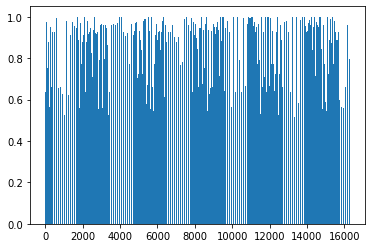

In [15]:

y_pos = np.arange(len(y_pred))
 
# Create bars
plt.bar(y_pos, y_conf)
 
# Create names on the x-axis
# plt.xticks(y_pos, bars)
 
# Show graphic
plt.show()


In [ ]:
# save model
# filename = f'{dataset}_rf_{acc}.pkl'
# with open(os.path.join('models', filename), 'wb') as rf_fd:
#     pickle.dump(rf, rf_fd)